## Testing `xvec` for hydrologic futures data

This notebook tests the `xvec` package to see if we can combine NHM hydrography vector data with the modeled hydrologic data that we reformatted as netCDF. The ideal outcome is to avoid crosswalking the modeled values to a shapefile, and instead have both the multidimensional modeled values and the geometry in one file.

Note that only the stream segments are tested in this notebook. We assume that line and polygon vector data will work the same way. 

### Setup

The `snap-geo` environment is used in this notebook, with `xvec` added.

In [459]:
import geopandas as gpd
import pandas as pd
import xarray as xr
import xvec
import numpy as np
from shapely.geometry import Point, box
from pathlib import Path
import os

# local copy of the data to avoid heavy processing on Chinook login node
data_dir = Path('/Users/joshpaul/secasc_hydroviz/hydroviz_data/')

Read in the NHM stream segments shapefile and the segment data netCDF, and check them out.

In [460]:
seg_gdf = gpd.read_file(os.path.join(data_dir, 'gis', 'Segments_subset.shp'))
seg_ds = xr.open_dataset(os.path.join(data_dir, 'nc', 'seg.nc'))

In [461]:
seg_gdf.reset_index(names="seg_id", inplace=True)
seg_gdf

seg_id region  seg_id_nat  \
0           0     01           1   
1           1     01           2   
2           2     01           3   
3           3     01           4   
4           4     01           5   
...       ...    ...         ...   
56455   56455     18       56456   
56456   56456     18       56457   
56457   56457     18       56458   
56458   56458     18       56459   
56459   56459     18       56460   

                                                geometry  
0      LINESTRING (2101948.624 2876678.641, 2101941.3...  
1      LINESTRING (2167789.031 2829021.852, 2167729.9...  
2      LINESTRING (2131936.492 2865675.020, 2131955.7...  
3      LINESTRING (2151719.943 2849594.051, 2151812.0...  
4      LINESTRING (2155981.103 2842240.715, 2155894.2...  
...                                                  ...  
56455  LINESTRING (-1943922.030 1664269.470, -1943834...  
56456  LINESTRING (-1939576.427 1684173.491, -1939582...  
56457  LINESTRING (-1941082.934 1778819.137, -1941078...  
56458  LINESTRING (-2283644.191 2427521.123, -2283652...  
56459  LINESTRING (-1943254.921 1411652.285, -1943311...  

[56460 rows x 4 columns]

In [462]:
seg_ds

<xarray.Dataset> Size: 5GB
Dimensions:   (lc: 2, model: 13, scenario: 5, era: 4, geom_id: 56540)
Coordinates:
  * lc        (lc) <U7 56B 'dynamic' 'static'
  * model     (model) <U14 728B 'ACCESS1-0' 'BNU-ESM' ... 'bcc-csm1-1'
  * scenario  (scenario) <U10 200B 'historical' 'rcp26' 'rcp45' 'rcp60' 'rcp85'
  * era       (era) <U13 208B 'historical' 'early_century' ... 'late_century'
  * geom_id   (geom_id) <U5 1MB '1' '2' '3' '4' ... '56538' '56539' '56540'
Data variables: (12/23)
    dh3       (lc, model, scenario, era, geom_id) float64 235MB ...
    dh15      (lc, model, scenario, era, geom_id) float64 235MB ...
    dl3       (lc, model, scenario, era, geom_id) float64 235MB ...
    dl16      (lc, model, scenario, era, geom_id) float64 235MB ...
    fh1       (lc, model, scenario, era, geom_id) float64 235MB ...
    fl1       (lc, model, scenario, era, geom_id) float64 235MB ...
    ...        ...
    ma22      (lc, model, scenario, era, geom_id) float64 235MB ...
    ma23      (lc, model, scenario, era, geom_id) float64 235MB ...
    ra1       (lc, model, scenario, era, geom_id) float64 235MB ...
    ra3       (lc, model, scenario, era, geom_id) float64 235MB ...
    th1       (lc, model, scenario, era, geom_id) float64 235MB ...
    tl1       (lc, model, scenario, era, geom_id) float64 235MB ...

### Data cleaning

We have to do some cleaning of the shapefile first, because the number of segments (`geom_id` values) in the dataset do not match the number of segments in th shapefile!

In [463]:
print(len(np.unique(seg_ds.geom_id)))

print(len(np.unique(seg_gdf.seg_id)))

56540
56460


For each `geom_id` that is missing from the shapefile, create a new dataframe with an empty geometry and no attributes. Then concat all dataframes together to fill in the missing values. We need to do this because we are going to relate the sahpefile geometry 1:1 with the `geom_id` values.

In [464]:
dfs_to_concat = []

empty = Point()

max_index = seg_gdf.index.max()

for ds_geom_id in list(np.unique(seg_ds.geom_id).astype(int)):
    if ds_geom_id not in seg_gdf.seg_id:
        dfs_to_concat.append(
            pd.DataFrame({'seg_id': ds_geom_id, 
                      'region': None, 
                      'seg_id_nat': None,
                      'geometry': empty},
                      index=[max_index+1],
                      ))
        max_index += 1

seg_gdf_filled = pd.concat([seg_gdf, pd.concat(dfs_to_concat)], ignore_index=True)

seg_gdf_filled

seg_id region seg_id_nat  \
0           0     01          1   
1           1     01          2   
2           2     01          3   
3           3     01          4   
4           4     01          5   
...       ...    ...        ...   
56536   56536   None       None   
56537   56537   None       None   
56538   56538   None       None   
56539   56539   None       None   
56540   56540   None       None   

                                                geometry  
0      LINESTRING (2101948.624 2876678.641, 2101941.3...  
1      LINESTRING (2167789.031 2829021.852, 2167729.9...  
2      LINESTRING (2131936.492 2865675.020, 2131955.7...  
3      LINESTRING (2151719.943 2849594.051, 2151812.0...  
4      LINESTRING (2155981.103 2842240.715, 2155894.2...  
...                                                  ...  
56536                                        POINT EMPTY  
56537                                        POINT EMPTY  
56538                                        POINT EMPTY  
56539                                        POINT EMPTY  
56540                                        POINT EMPTY  

[56541 rows x 4 columns]

Looks like we have one extra row! The netCDF does not include a `geom_id` of 0, but the shapefile does. For now, we will just drop this row from the shapefile.

In [465]:
set(seg_ds.geom_id.astype(int).values).symmetric_difference(set(seg_gdf_filled.seg_id))

{0}

In [466]:
seg_gdf_filled = seg_gdf_filled.drop(index=0)

Now we can set the index and rename it to match the coordinate name in the netCDF.

In [467]:
seg_gdf_filled.index.rename('geom_id', inplace=True)
seg_gdf_filled


seg_id region seg_id_nat  \
geom_id                             
1             1     01          2   
2             2     01          3   
3             3     01          4   
4             4     01          5   
5             5     01          6   
...         ...    ...        ...   
56536     56536   None       None   
56537     56537   None       None   
56538     56538   None       None   
56539     56539   None       None   
56540     56540   None       None   

                                                  geometry  
geom_id                                                     
1        LINESTRING (2167789.031 2829021.852, 2167729.9...  
2        LINESTRING (2131936.492 2865675.020, 2131955.7...  
3        LINESTRING (2151719.943 2849594.051, 2151812.0...  
4        LINESTRING (2155981.103 2842240.715, 2155894.2...  
5        LINESTRING (2169381.995 2828135.505, 2169214.0...  
...                                                    ...  
56536                                          POINT EMPTY  
56537                                          POINT EMPTY  
56538                                          POINT EMPTY  
56539                                          POINT EMPTY  
56540                                          POINT EMPTY  

[56540 rows x 4 columns]

### Add vector data to `xarray.Dataset`

Now we are ready to add the vector data. We do this by replacing the values in the `geom_id` dimensional coordinate with actual `shapely` geometries from the shapefile. For this to work, the index of the `GeoDataFrame` must be a 1:1 match with the coordinates in the `xarray.Dataset`. In this case they are integers, but non-numeric string coordinates should work just the same. 

In [468]:
seg_ds["geom_id"] = seg_ds["geom_id"].astype(int)
seg_ds["geom_id"] = seg_gdf_filled.loc[seg_ds.geom_id].geometry

seg_ds

<xarray.Dataset> Size: 5GB
Dimensions:   (lc: 2, model: 13, scenario: 5, era: 4, geom_id: 56540)
Coordinates:
  * lc        (lc) <U7 56B 'dynamic' 'static'
  * model     (model) <U14 728B 'ACCESS1-0' 'BNU-ESM' ... 'bcc-csm1-1'
  * scenario  (scenario) <U10 200B 'historical' 'rcp26' 'rcp45' 'rcp60' 'rcp85'
  * era       (era) <U13 208B 'historical' 'early_century' ... 'late_century'
  * geom_id   (geom_id) object 452kB LINESTRING (2167789.031300001 2829021.85...
Data variables: (12/23)
    dh3       (lc, model, scenario, era, geom_id) float64 235MB ...
    dh15      (lc, model, scenario, era, geom_id) float64 235MB ...
    dl3       (lc, model, scenario, era, geom_id) float64 235MB ...
    dl16      (lc, model, scenario, era, geom_id) float64 235MB ...
    fh1       (lc, model, scenario, era, geom_id) float64 235MB ...
    fl1       (lc, model, scenario, era, geom_id) float64 235MB ...
    ...        ...
    ma22      (lc, model, scenario, era, geom_id) float64 235MB ...
    ma23      (lc, model, scenario, era, geom_id) float64 235MB ...
    ra1       (lc, model, scenario, era, geom_id) float64 235MB ...
    ra3       (lc, model, scenario, era, geom_id) float64 235MB ...
    th1       (lc, model, scenario, era, geom_id) float64 235MB ...
    tl1       (lc, model, scenario, era, geom_id) float64 235MB ...

We can see that the original segment IDs have been replaced with `shapely` linestrings. And checking the coordinates, we see the `*` indicating that the `geom_id` coordinate is still a dimensional coordinate.

In [469]:
seg_ds.coords

Coordinates:
  * lc        (lc) <U7 56B 'dynamic' 'static'
  * model     (model) <U14 728B 'ACCESS1-0' 'BNU-ESM' ... 'bcc-csm1-1'
  * scenario  (scenario) <U10 200B 'historical' 'rcp26' 'rcp45' 'rcp60' 'rcp85'
  * era       (era) <U13 208B 'historical' 'early_century' ... 'late_century'
  * geom_id   (geom_id) object 452kB LINESTRING (2167789.031300001 2829021.85...

But does the coordinate have an index that we can use for querying?

In [470]:
seg_ds.xvec.geom_coords_indexed

Coordinates:
    *empty*

Nope. We have to set this manually and provide a CRS from the original shapefile.

In [471]:
seg_ds = seg_ds.xvec.set_geom_indexes("geom_id", crs=seg_gdf.crs)

Let's see what happened... do we have geometry coordinates now? This should return any coordinate variables composed of `shapely.Geometry` objects.

In [472]:
seg_ds.xvec.geom_coords_indexed

Coordinates:
  * geom_id  (geom_id) object 452kB LINESTRING (2167789.031300001 2829021.851...

And the `geom_id` coordinate should be in class `xvec.GeometryIndex` with an associated CRS...

In [473]:
seg_ds.xindexes

Indexes:
    lc        PandasIndex
    model     PandasIndex
    scenario  PandasIndex
    era       PandasIndex
    geom_id   GeometryIndex (crs=ESRI:102039)

Great! Now we can add the segment IDs as non-dimensional coordinates attached to the `geom_id` dimensional coordinate. We can use these later to query by segment ID, and they will be returned along with any query we make using `geom_id`. You could imagine adding additional attribute info about the segments in another non-dimensional coordinate linked to `geom_id`, and for each `geom_id` value there could be a dictionary of attributes (e.g. region, stream order, etc.) that would be returned by any `geom_id`-based query.

In [474]:
seg_ds = seg_ds.assign_coords(seg_id=("geom_id", seg_gdf_filled.index))
seg_ds

<xarray.Dataset> Size: 5GB
Dimensions:   (lc: 2, model: 13, scenario: 5, era: 4, geom_id: 56540)
Coordinates:
  * lc        (lc) <U7 56B 'dynamic' 'static'
  * model     (model) <U14 728B 'ACCESS1-0' 'BNU-ESM' ... 'bcc-csm1-1'
  * scenario  (scenario) <U10 200B 'historical' 'rcp26' 'rcp45' 'rcp60' 'rcp85'
  * era       (era) <U13 208B 'historical' 'early_century' ... 'late_century'
  * geom_id   (geom_id) object 452kB LINESTRING (2167789.031300001 2829021.85...
    seg_id    (geom_id) int64 452kB 1 2 3 4 5 ... 56536 56537 56538 56539 56540
Data variables: (12/23)
    dh3       (lc, model, scenario, era, geom_id) float64 235MB ...
    dh15      (lc, model, scenario, era, geom_id) float64 235MB ...
    dl3       (lc, model, scenario, era, geom_id) float64 235MB ...
    dl16      (lc, model, scenario, era, geom_id) float64 235MB ...
    fh1       (lc, model, scenario, era, geom_id) float64 235MB ...
    fl1       (lc, model, scenario, era, geom_id) float64 235MB ...
    ...        ...
    ma22      (lc, model, scenario, era, geom_id) float64 235MB ...
    ma23      (lc, model, scenario, era, geom_id) float64 235MB ...
    ra1       (lc, model, scenario, era, geom_id) float64 235MB ...
    ra3       (lc, model, scenario, era, geom_id) float64 235MB ...
    th1       (lc, model, scenario, era, geom_id) float64 235MB ...
    tl1       (lc, model, scenario, era, geom_id) float64 235MB ...
Indexes:
    geom_id  GeometryIndex (crs=ESRI:102039)

### Query `xarray.Dataset` using geometry

So how can we use the new geometry in the dataset? 

#### 1: Use the non-dimensional `seg_id` coordinate to query segment(s) by ID and get associated data

We could use this method if we already have a reference for the segment(s) we want to select, maybe from a pre-configured lookup table (e.g. a list of the segment IDs that fall within the polygon for Denali National Park). Here the segment IDs are unique integers, but this should also work if the IDs were non-numeric strings. We make a list of them to use in a query, and since the segment IDs in `seg_id` coordinate are associated with the `geom_id` coordinate, we get the actual geometry returned along with the data.


In [475]:
# test segments
segment_ids = [10, 11, 12, 13]
# query for data associated with those segments
seg_ds.sel(geom_id = seg_ds.seg_id.isin(segment_ids))

<xarray.Dataset> Size: 384kB
Dimensions:   (lc: 2, model: 13, scenario: 5, era: 4, geom_id: 4)
Coordinates:
  * lc        (lc) <U7 56B 'dynamic' 'static'
  * model     (model) <U14 728B 'ACCESS1-0' 'BNU-ESM' ... 'bcc-csm1-1'
  * scenario  (scenario) <U10 200B 'historical' 'rcp26' 'rcp45' 'rcp60' 'rcp85'
  * era       (era) <U13 208B 'historical' 'early_century' ... 'late_century'
  * geom_id   (geom_id) object 32B LINESTRING (2125582.216699999 2869165.501,...
    seg_id    (geom_id) int64 32B 10 11 12 13
Data variables: (12/23)
    dh3       (lc, model, scenario, era, geom_id) float64 17kB ...
    dh15      (lc, model, scenario, era, geom_id) float64 17kB ...
    dl3       (lc, model, scenario, era, geom_id) float64 17kB ...
    dl16      (lc, model, scenario, era, geom_id) float64 17kB ...
    fh1       (lc, model, scenario, era, geom_id) float64 17kB ...
    fl1       (lc, model, scenario, era, geom_id) float64 17kB ...
    ...        ...
    ma22      (lc, model, scenario, era, geom_id) float64 17kB ...
    ma23      (lc, model, scenario, era, geom_id) float64 17kB ...
    ra1       (lc, model, scenario, era, geom_id) float64 17kB ...
    ra3       (lc, model, scenario, era, geom_id) float64 17kB ...
    th1       (lc, model, scenario, era, geom_id) float64 17kB ...
    tl1       (lc, model, scenario, era, geom_id) float64 17kB ...
Indexes:
    geom_id  GeometryIndex (crs=ESRI:102039)

In [476]:
# make a more specific request for those 4 stream segment IDs, and get a data value for a specific variable / model / scenario / era combo

var = 'fl1'

seg_ds[var].sel(geom_id = seg_ds.seg_id.isin(segment_ids),
               lc="dynamic",
               model="CCSM4",
               scenario="rcp85",
               era="late_century",
               ).values

array([20.767, 20.   , 17.067, 10.633])

In [477]:
# and a separate query for the actual shapely geometry for those segments

seg_ds.sel(geom_id = seg_ds.seg_id.isin(segment_ids)).geom_id.values

array([<LINESTRING (2125582.217 2869165.501, 2125591.891 2869161.644, 2125599.156 2...>,
       <LINESTRING (2125675.81 2869977.504, 2125666.691 2869985.87, 2125655.633 286...>,
       <LINESTRING (2133073.871 2828807.126, 2133044.841 2828753.384, 2133028.711 2...>,
       <LINESTRING (2150342.002 2844865.501, 2150334.998 2844844.5, 2150299.997 284...>],
      dtype=object)

#### 2: In cases where we do not have the segment IDs, use a variety of spatial queries



##### 2a: Provide a point and query with `method='nearest'`

In [478]:
seg_ds[var].sel(geom_id= Point(2130000, 2860000), 
                method= "nearest").sel(
                    lc= "dynamic",
                    model= "CCSM4",
                    scenario= "rcp85",
                    era= "late_century",
                    ).values


array([14.833])

In [479]:
# and a separate query for the actual shapely geometry for those segments

seg_ds.sel(geom_id= Point(2130000, 2860000), 
           method= "nearest").geom_id.values

array([<LINESTRING (2131936.492 2865675.02, 2131955.799 2865619.886, 2131961.97 286...>],
      dtype=object)

##### 2b: Select using a bounding box with `method='intersects'`


In [480]:
seg_ds[var].sel(geom_id=box(2160000, 2820000, 2170000, 2830000), 
           method="intersects").sel(
                lc="dynamic",
                model="CCSM4",
                scenario="rcp85",
                era="late_century",
                ).values

array([12.567, 27.6  ])

In [481]:
# and a separate query for the actual shapely geometry for those segments intersecting the box

seg_ds.sel(geom_id=box(2160000, 2820000, 2170000, 2830000), 
           method="intersects").geom_id.values

array([<LINESTRING (2169381.995 2828135.505, 2169214.004 2828219.5, 2168975.999 282...>,
       <LINESTRING (2167789.031 2829021.852, 2167729.997 2829073.498, 2167674.002 2...>],
      dtype=object)

##### 2c: Use a buffer around a point with `method='dwithin'` (distance within)

I'm not quite sure if this is a circular buffer. Also note that this will return a cryptic error if the distance is too small and doesn't return any shapes within the buffer! 

In [482]:
# returns the whole dataset that occurs within the buffer
seg_ds[var].xvec.query(
    "geom_id",
    Point(2130000, 2860000),
    predicate="dwithin",
    unique=True,
    distance=10000,
)

<xarray.DataArray 'fl1' (lc: 2, model: 13, scenario: 5, era: 4, geom_id: 3)> Size: 12kB
[1560 values with dtype=float64]
Coordinates:
  * lc        (lc) <U7 56B 'dynamic' 'static'
  * model     (model) <U14 728B 'ACCESS1-0' 'BNU-ESM' ... 'bcc-csm1-1'
  * scenario  (scenario) <U10 200B 'historical' 'rcp26' 'rcp45' 'rcp60' 'rcp85'
  * era       (era) <U13 208B 'historical' 'early_century' ... 'late_century'
  * geom_id   (geom_id) object 24B LINESTRING (2131936.4919999987 2865675.020...
    seg_id    (geom_id) int64 24B 2 11 10
Indexes:
    geom_id  GeometryIndex (crs=ESRI:102039)

In [483]:
# then we can complete the query as before
seg_ds[var].xvec.query(
    "geom_id",
    Point(2130000, 2860000),
    predicate="dwithin",
    unique=True,
    distance=10000,
    ).sel(
        lc="dynamic",
        model="CCSM4",
        scenario="rcp85",
        era="late_century",
        ).values

array([14.833, 20.   , 20.767])

#### Plotting

OK lets take the examples above and turn the query results into a geodataframe for plotting. We essentially just add this suffix to each query: 

```.xvec.to_geodataframe(geometry="geom_id")```

For each plot, we will just use the variable to specify the column for adding default colors to the plot.

In [484]:
# 1:
gdf_1 = seg_ds[var].sel(geom_id = seg_ds.seg_id.isin(segment_ids),
               lc="dynamic",
               model="CCSM4",
               scenario="rcp85",
               era="late_century",
               ).xvec.to_geodataframe(geometry="geom_id")

gdf_1

geom_id       lc  model scenario  \
0  LINESTRING (2125582.217 2869165.501, 2125591.8...  dynamic  CCSM4    rcp85   
1  LINESTRING (2125675.810 2869977.504, 2125666.6...  dynamic  CCSM4    rcp85   
2  LINESTRING (2133073.871 2828807.126, 2133044.8...  dynamic  CCSM4    rcp85   
3  LINESTRING (2150342.002 2844865.501, 2150334.9...  dynamic  CCSM4    rcp85   

            era  seg_id     fl1  
0  late_century      10  20.767  
1  late_century      11  20.000  
2  late_century      12  17.067  
3  late_century      13  10.633

<Axes: >

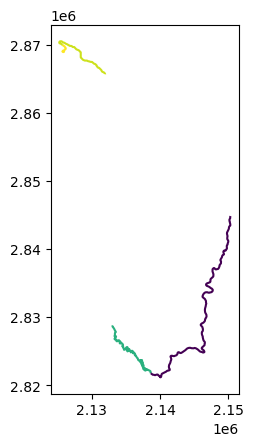

In [485]:
gdf_1.plot(column=var)

In [486]:
# 2a:
gdf_2a = seg_ds[var].sel(geom_id= Point(2130000, 2860000), 
                method= "nearest").sel(
                    lc= "dynamic",
                    model= "CCSM4",
                    scenario= "rcp85",
                    era= "late_century",
                    ).xvec.to_geodataframe(geometry="geom_id")

gdf_2a

geom_id       lc  model scenario  \
0  LINESTRING (2131936.492 2865675.020, 2131955.7...  dynamic  CCSM4    rcp85   

            era  seg_id     fl1  
0  late_century       2  14.833

<Axes: >

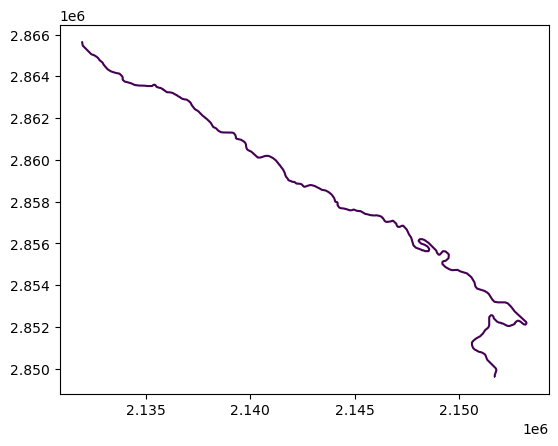

In [487]:
gdf_2a.plot(column=var)

In [488]:
# 2b:
gdf_2b = seg_ds[var].sel(geom_id=box(2160000, 2820000, 2170000, 2830000), 
           method="intersects").sel(
                lc="dynamic",
                model="CCSM4",
                scenario="rcp85",
                era="late_century",
                ).xvec.to_geodataframe(geometry="geom_id")

gdf_2b

geom_id       lc  model scenario  \
0  LINESTRING (2169381.995 2828135.505, 2169214.0...  dynamic  CCSM4    rcp85   
1  LINESTRING (2167789.031 2829021.852, 2167729.9...  dynamic  CCSM4    rcp85   

            era  seg_id     fl1  
0  late_century       5  12.567  
1  late_century       1  27.600

<Axes: >

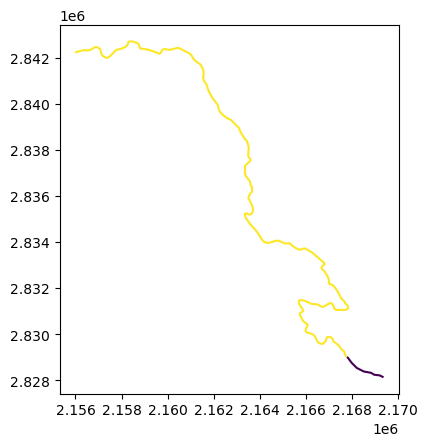

In [489]:
gdf_2b.plot(column=var)

In [490]:
# 2c:
gdf_2c = seg_ds[var].xvec.query(
    "geom_id",
    Point(2130000, 2860000),
    predicate="dwithin",
    unique=True,
    distance=10000,
    ).sel(
        lc="dynamic",
        model="CCSM4",
        scenario="rcp85",
        era="late_century",
        ).xvec.to_geodataframe(geometry="geom_id")

gdf_2c

geom_id       lc  model scenario  \
0  LINESTRING (2131936.492 2865675.020, 2131955.7...  dynamic  CCSM4    rcp85   
1  LINESTRING (2125675.810 2869977.504, 2125666.6...  dynamic  CCSM4    rcp85   
2  LINESTRING (2125582.217 2869165.501, 2125591.8...  dynamic  CCSM4    rcp85   

            era  seg_id     fl1  
0  late_century       2  14.833  
1  late_century      11  20.000  
2  late_century      10  20.767

<Axes: >

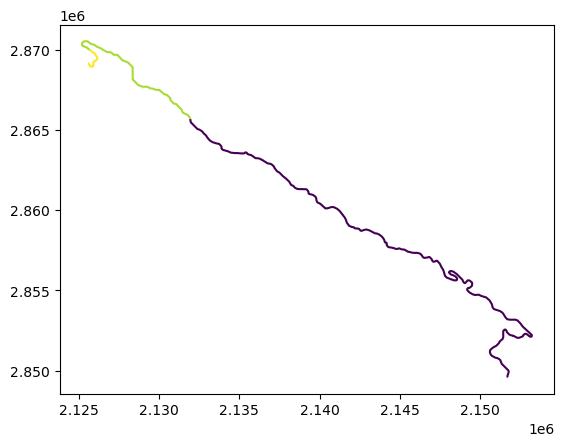

In [491]:
gdf_2c.plot(column=var)